# US electricity consumption and production analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Notes:

Net generation excludes electricity use for power plant operations.
Terawatt hours, abbreviated as TWh, is a unit of energy representing one trillion watt hours.

Important links

[Electricity generation, capacity, and sales in the United States
](https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php#:~:text=In%202022%2C%20net%20generation%20of,solar%20photovoltaic%20(PV)%20systems.)

[Electricity data browser
](https://www.eia.gov/electricity/data.php)


Start with net generation data

#### Run the following packages to get Data

Power generation data

In [2]:
from EIA_DATA.generation_data import get_generation_data

In [3]:
raw_gneration_df = get_generation_data()

Power Plant data

In [4]:
from EIA_DATA.plant_data import get_plant_data

In [5]:
raw_plant_df = get_plant_data()

Successfully downloaded and unzipped https://www.eia.gov/electricity/data/eia860/xls/eia8602022.zip


# Clean the data

### First the generation data

When we got the data from the excel file it grabbed rows above the headers. We can find all values in the 'YEAR' column and remove them from the dataframe. We can also remove rows that have values that are NaN. We can also check the integrity of the data by looking for duplicate rows. 

In [6]:
invalid_rows = raw_gneration_df[raw_gneration_df['YEAR'].str.isnumeric() == False]
gen_df = raw_gneration_df.drop(invalid_rows.index).dropna()
gen_df.duplicated().sum()



0

To ensure we didn't have change our data too much we check the shape of the dataframe before and after.

In [7]:
print("Shape of raw_df:")
print(raw_gneration_df.shape)

print("\nShape of df:")
print(gen_df.shape)

removed_rows = raw_gneration_df.shape[0] - gen_df.shape[0]
print(f'We removed {removed_rows} row(s).')

Shape of raw_df:
(530838, 6)

Shape of df:
(530790, 6)
We removed 48 row(s).


We can change the date types to make our data easier to work with. Then check what they are after we have changed them.

In [8]:
gen_df = gen_df.infer_objects()
gen_df.dtypes


YEAR                            int64
MONTH                           int64
STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

We want to take the year and month columns and convert them into a date colum we can use to index the dataframe. We dont have a day of the month so we just use a constant value of 1. We can not get rid of the year and month columns to clean up the dataframe. We also want to infer objects again because we changed the headers and added a datetime column.

In [9]:
gen_df['DATE'] = pd.to_datetime(gen_df[['YEAR', 'MONTH']].assign(day=1),errors='coerce')
gen_df.set_index('DATE', inplace=True)
gen_df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
gen_df.head()

gen_df = gen_df.infer_objects()
gen_df.dtypes


,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903.0
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085.0
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521.0
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
2001-01-01,AK,Total Electric Power Industry,Wind,87.0


Converting the 'STATE' column to uppercase ensures a consistent and standardized representation of state names.

In [10]:
gen_df['STATE'] = gen_df['STATE'].str.upper()

The unit Megawatt-hours (MWh) is very small when dealing with net generation so we will reduce it to make it more manageable. We are going to use a Terawatt-hour (TWh) which is equal to 1 million Megawatt-hours. For reference the average house hold uses 10,632 kilowatt-hours per year or .00001063 TWh.

In [16]:
gen_df["Generation (TWh)"] = gen_df["GENERATION (Megawatthours)"]/1000000
gen_df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)

### Now the power plant data

In [17]:
raw_plant_df.columns

Index(['Utility ID', 'Utility Name_x', 'Plant Code_x', 'Plant Name_x',
       'Street Address', 'City', 'State_x', 'Zip', 'County_x', 'Latitude',
       ...
       'Planned Energy Source 1', 'Planned New Nameplate Capacity (MW)',
       'Planned Repower Month', 'Planned Repower Year',
       'Other Planned Modifications?', 'Other Modifications Month',
       'Other Modifications Year', 'Multiple Fuels?', 'Cofire Fuels?',
       'Switch Between Oil and Natural Gas?'],
      dtype='object', length=114)

In [18]:
raw_plant_df.duplicated().sum()

0

### Make some copies of the data

Now that we have our data cleaned we will make a copy of the data frame to hold entegrity of the data

In [19]:
raw_df_copy = gen_df.copy()
raw_df_copy.shape

(530790, 4)

We will also make the df into a csv if we need to pull into excel to better understand

In [20]:
raw_plant_df.to_csv('planttest.csv', index=False)

gen_df_reset = gen_df.reset_index()
gen_df_reset.to_csv('net_generation_df.csv', index=True)

# Start of analysis

### Getting to know the data

We need to know more about the gen_df DataFrame to start

To better understand our data we can get all they types of producers and the types of energy sources by using the .unique() method. This will also help us validate that we cleaned the data correctly. 

In [38]:
types_producer = gen_df['TYPE OF PRODUCER'].unique()
types_producer

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Independent Power Producers'], dtype=object)

In [39]:
gen_df['ENERGY SOURCE'].unique()

array(['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional',
       'Wind', 'Total', 'Other Gases', 'Nuclear',
       'Wood and Wood Derived Fuels', 'Other Biomass', 'Other',
       'Solar Thermal and Photovoltaic', 'Pumped Storage', 'Geothermal'],
      dtype=object)

We can check on 'GENERATION (Twh)' column and get some statistics that will describe our dataset. 

In [41]:
gen_df['Generation (TWh)'].describe()

count    530790.000000
mean          1.390318
std          10.785769
min          -0.997855
25%           0.001574
50%           0.022916
75%           0.277950
max         425.611328
Name: Generation (TWh), dtype: float64

We see that our standard diviation is very high and there is a large gap between the percentiles. This tell us that there is many outliers and values that are zero. Anohter thing to note is that the min value is a negitive number. This is data on the generaion of electiricy so we went to know why type of energy source is pulling power instead of producing it. 

We can plot a histogram to see how the data is distributed and get a visual representation. 

<Axes: >

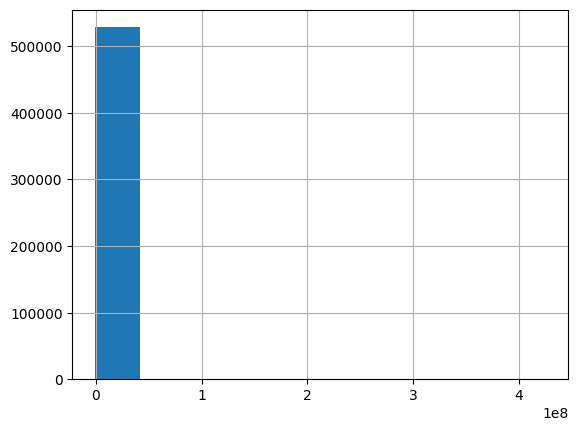

In [ ]:
gen_df['GENERATION (Megawatthours)'].hist()
#come back and add label and a title


The visual representation validates our observations from the describe() table, indicating a concentration of values around zero and notable outliers at the upper end. However, it's important to note that this graph represents a broad overview, encompassing diverse sources, states, and their totals spanning from 2001 to 2023. To narrow our focus and derive more targeted insights, we plan to apply filters, selecting specific subsets of data such as totals, specific sources, or particular states for further analysis.

In [ ]:
gen_df['TYPE OF PRODUCER'].value_counts()


TYPE OF PRODUCER
Total Electric Power Industry                       143564
Electric Generators, Electric Utilities             100222
Electric Generators, Independent Power Producers     95985
Combined Heat and Power, Industrial Power            82955
Combined Heat and Power, Commercial Power            58112
Combined Heat and Power, Electric Power              49952
Name: count, dtype: int64

We can see there are really three categories in the producer columns. 
- Electric Generators
- Combined Heat and Power
- Total Electric Power Industry

Each have a subcategory too.

We can now do the same for the plant_df DataFrame

# Key research areas

## Energy Consumption by State and Sector:


#### Understanding the Total electric power generation

We will start our analysis on the 'Total Electric Power Industry' to begin

Totals are already calculated in the df so we will just need to pull the right columns.

In [ ]:
total=gen_df.loc[gen_df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=total.loc[total['STATE']=='US-TOTAL']
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


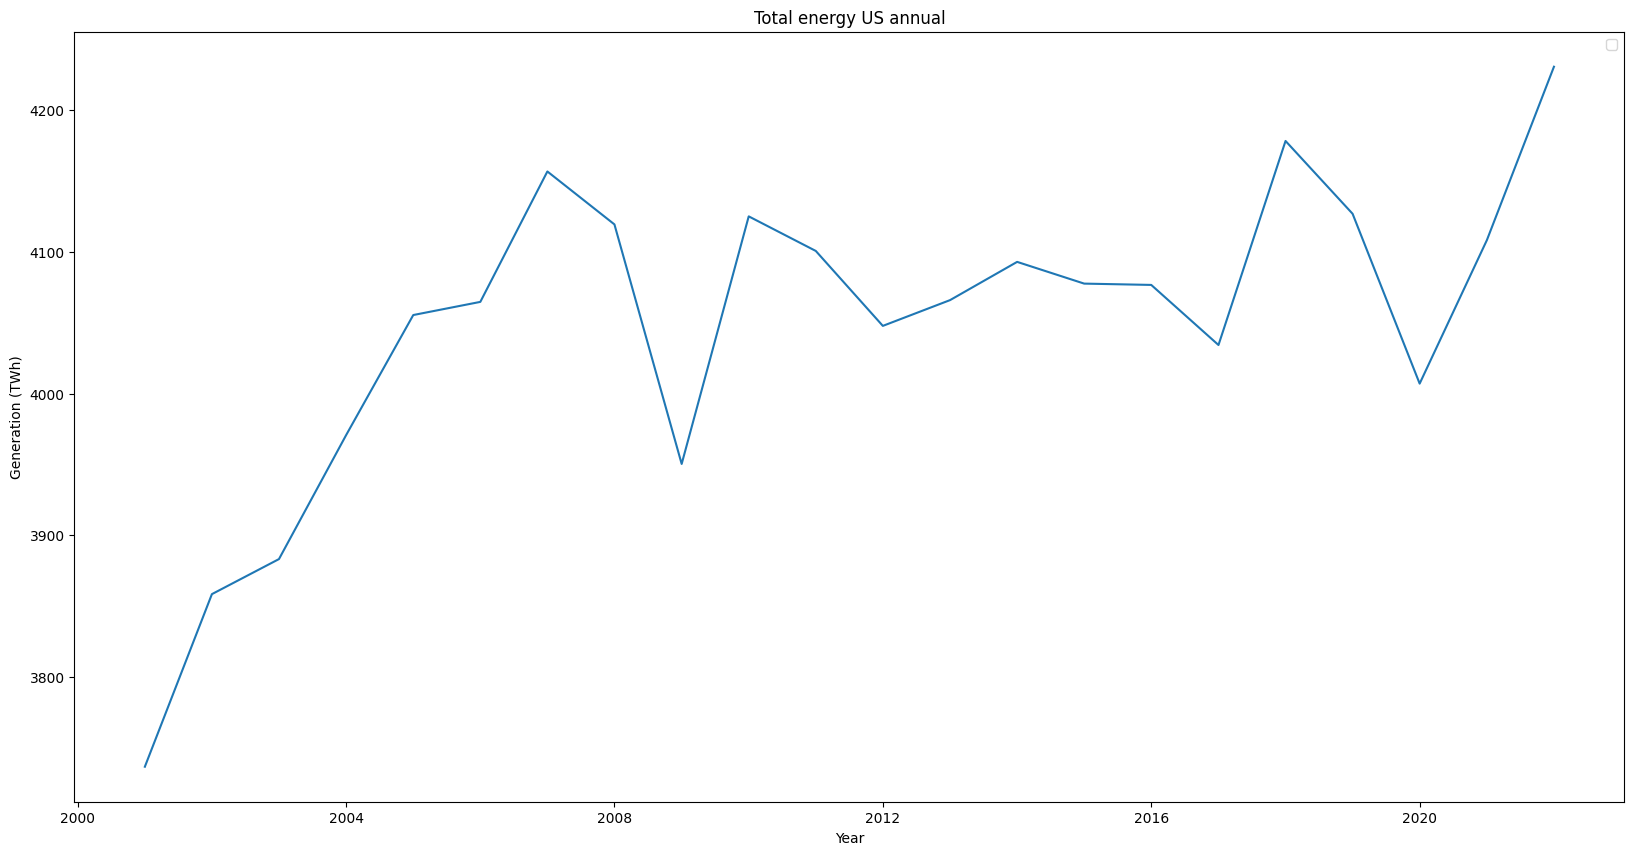

In [ ]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

US_total_year = US_total_month.groupby(US_total_month['DATE'].dt.year, as_index=False).agg({'DATE': 'first', 'Generation (TWh)': 'sum'})

US_total_year = US_total_year[US_total_year['DATE'].dt.year != 2023]

plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_total_year, x=US_total_year['DATE'] \
             ,y=US_total_year['Generation (TWh)'])
plt.title("Total energy US annual")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [ ]:
# add growth rates
test

#### Total US power generation by month

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


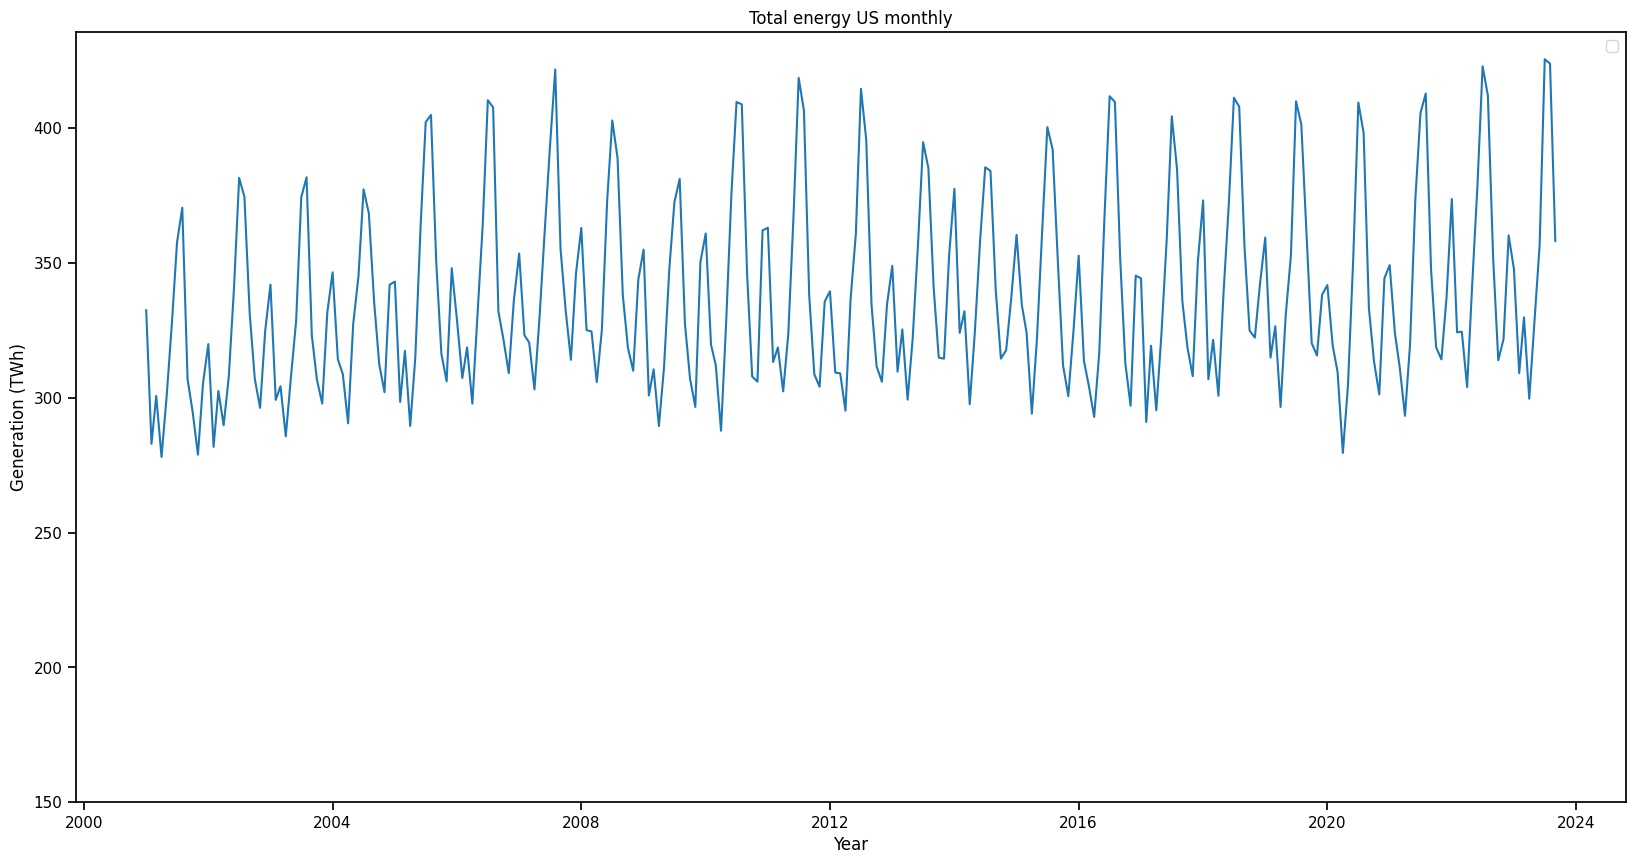

In [42]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_total_month, x=US_total_month['DATE'] \
             ,y=US_total_month['Generation (TWh)'])
plt.ylim(150, US_total_month['Generation (TWh)'].max() + 10) 
plt.title("Total energy US monthly")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

Now that we have looked at the totals we want to look net generation by state. So we dont double count any values we will make a DataFrame that is the inverse of the totals DataFrame by taking out all of the US-Total values. 

Similar to how we separated the totals from the rest of the data we will pull totals out so we dont double count when we group by states

In [ ]:
state_df = gen_df[(gen_df['STATE'] != 'US-TOTAL') & 
              (gen_df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (gen_df['ENERGY SOURCE'] == 'Total')]

Make some more DataFrames by grouping by states: month year and all-time

In [ ]:
state_total_month =state_df.groupby(by=[state_df.index,"STATE"]).sum().reset_index()
state_total_year =state_df.groupby(by=[state_df.index.year,"STATE"]).sum().reset_index()
state_total_alltime =state_df.groupby(by=["STATE"]).sum().reset_index().sort_values(by='Generation (TWh)')
state_total_alltime.shape

(51, 4)

By sorting the values we can see the state that has produced the most electricity in the last 22 years cumulative.

In [58]:
TimePeriodOfData = (state_df.index.year.unique().max()) - (state_df.index.year.unique().min())
TimePeriodOfData

22

In [57]:
state_total_month_top10=state_total_alltime[['STATE','Generation (TWh)']].sort_values(by='Generation (TWh)', ascending=False).iloc[:10]
state_total_month_top10[['STATE','Generation (TWh)']]

,STATE,Generation (TWh)
43,TX,9894.888992
9,FL,5218.290742
38,PA,5036.201059
4,CA,4568.488753
14,IL,4341.616358
1,AL,3261.197689
35,OH,3109.237906
34,NY,3088.521236
10,GA,2930.871739
27,NC,2882.807861


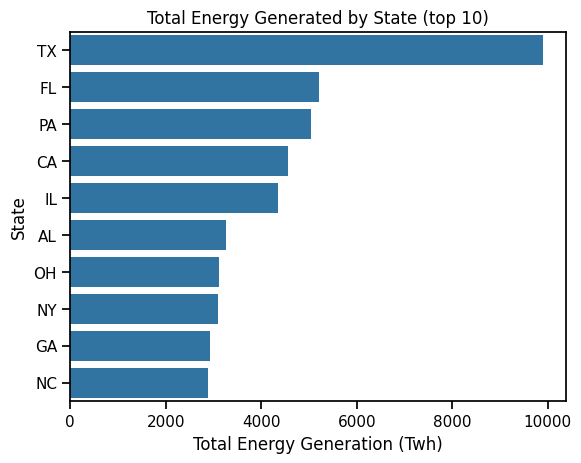

In [59]:
state_total_alltime['AVG Generation'] = state_total_alltime['Generation (TWh)']/TimePeriodOfData
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Generation (TWh)']/state_total_alltime['Generation (TWh)'].sum())
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Percent of total US generation'] * 100).map("{:.2f}%".format)


state_total_alltime[['STATE','Generation (TWh)','AVG Generation','Percent of total US generation']].sort_values(by= 'Generation (TWh)',ascending = False).head(5)

sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_month_top10,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State (top 10)')

plt.show()

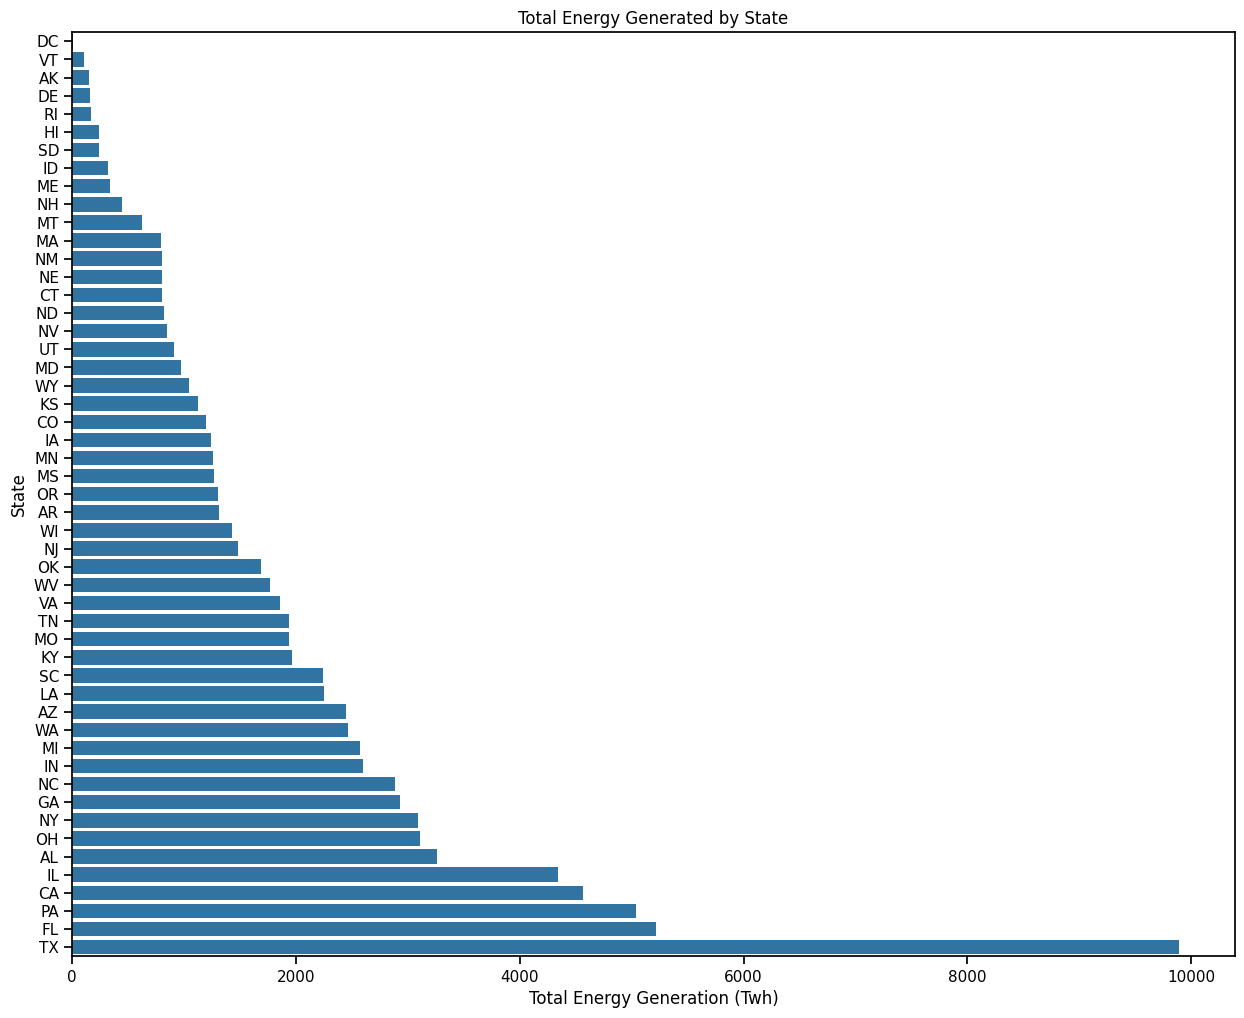

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_alltime,errorbar=None)
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State')

plt.show()

In [60]:
type_producer_year['TYPE OF PRODUCER'].unique()

array(['Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Electric Utilities',
       'Electric Generators, Independent Power Producers'], dtype=object)

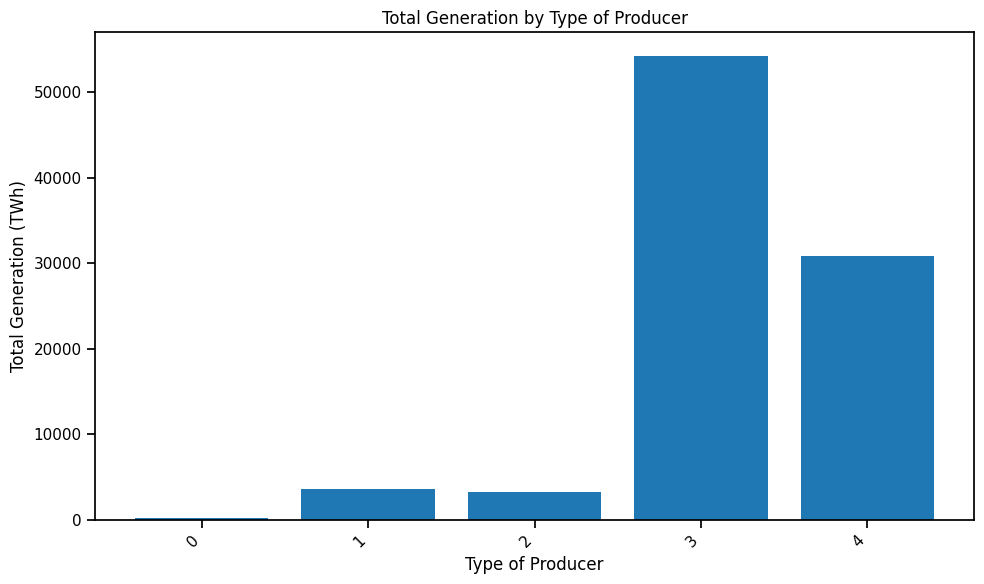

In [ ]:
type_producer = gen_df[(gen_df['STATE'] == 'US-TOTAL') & 
              (gen_df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (gen_df['ENERGY SOURCE'] == 'Total')].reset_index()

type_producer_year = type_producer.groupby(by = type_producer['TYPE OF PRODUCER']).sum('Generation (TWh)').reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_producer_year.index, type_producer_year['Generation (TWh)'])
plt.xlabel('Type of Producer')
plt.ylabel('Total Generation (TWh)')
plt.title('Total Generation by Type of Producer')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

Might want to add per capita data and graph it againt the total generation. 

## Energy Sources

In [45]:
US_source_no_total=US_source[(US_source['ENERGY SOURCE']!='Total')]
US_source_no_total[['DATE','ENERGY SOURCE','Generation (TWh)']].sort_values(by = 'Generation (TWh)', ascending= False).head()

,DATE,ENERGY SOURCE,Generation (TWh)
3783,2023-07-01,Natural Gas,200.506759
3797,2023-08-01,Natural Gas,199.993042
1106,2007-08-01,Coal,190.134816
938,2006-08-01,Coal,189.454930
3615,2022-07-01,Natural Gas,189.042160


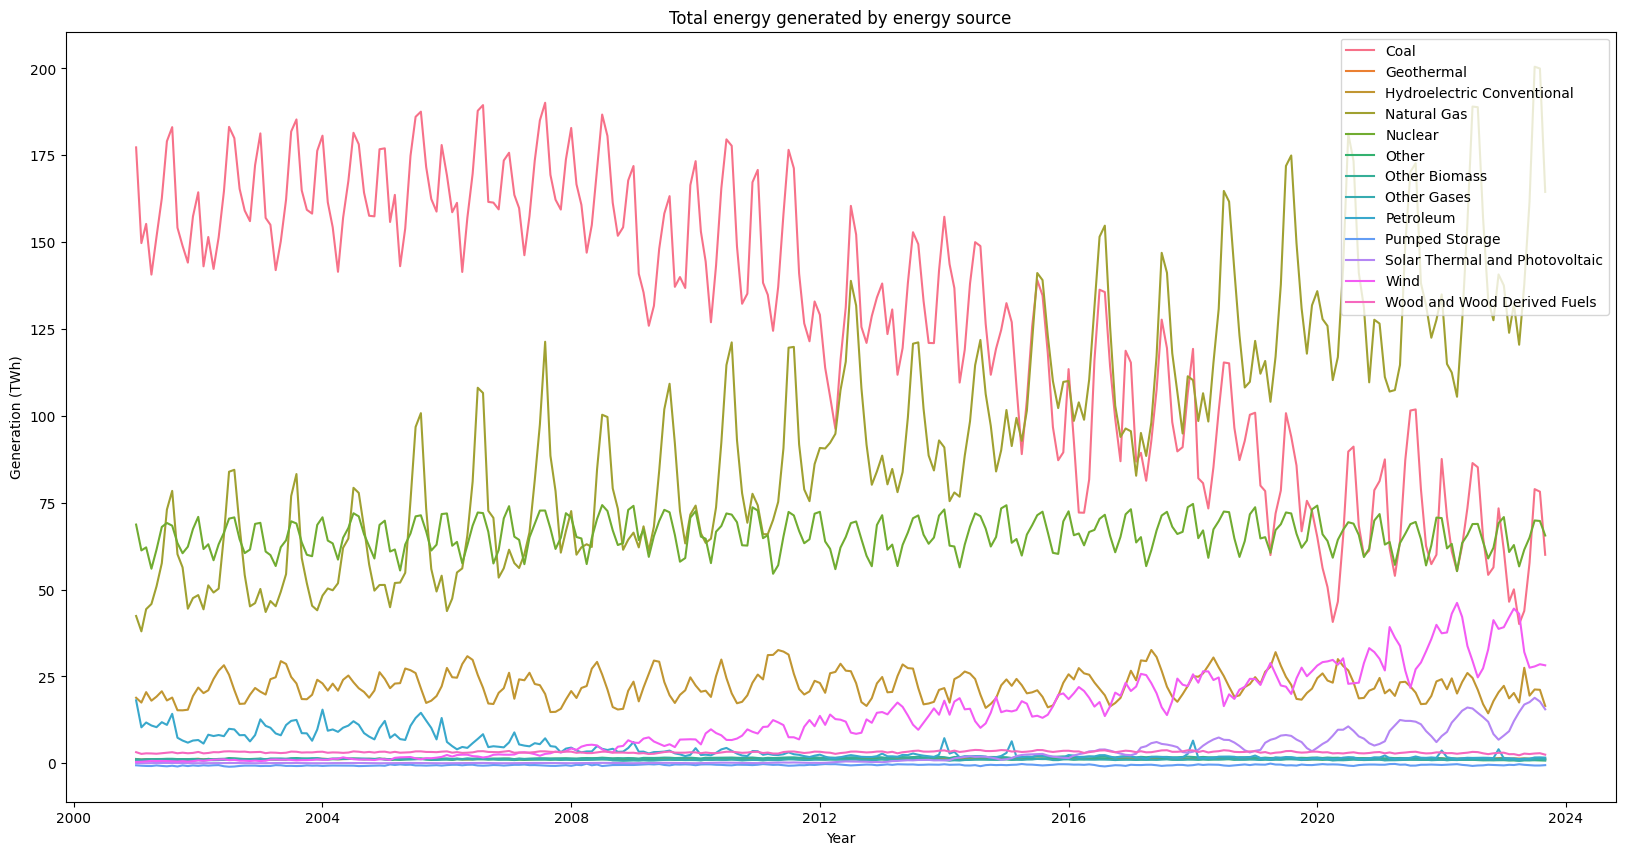

In [ ]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source_no_total, x=US_source_no_total['DATE'] \
             ,y=US_source_no_total['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [ ]:
#Trent add bar here

This chart is very busy so we can break down the energy sources into three groups High Med and Small

In [ ]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]
US_top3.head()

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
14,2001-02-01,Coal,US-TOTAL,Total Electric Power Industry,149.735484
17,2001-02-01,Natural Gas,US-TOTAL,Total Electric Power Industry,37.966927


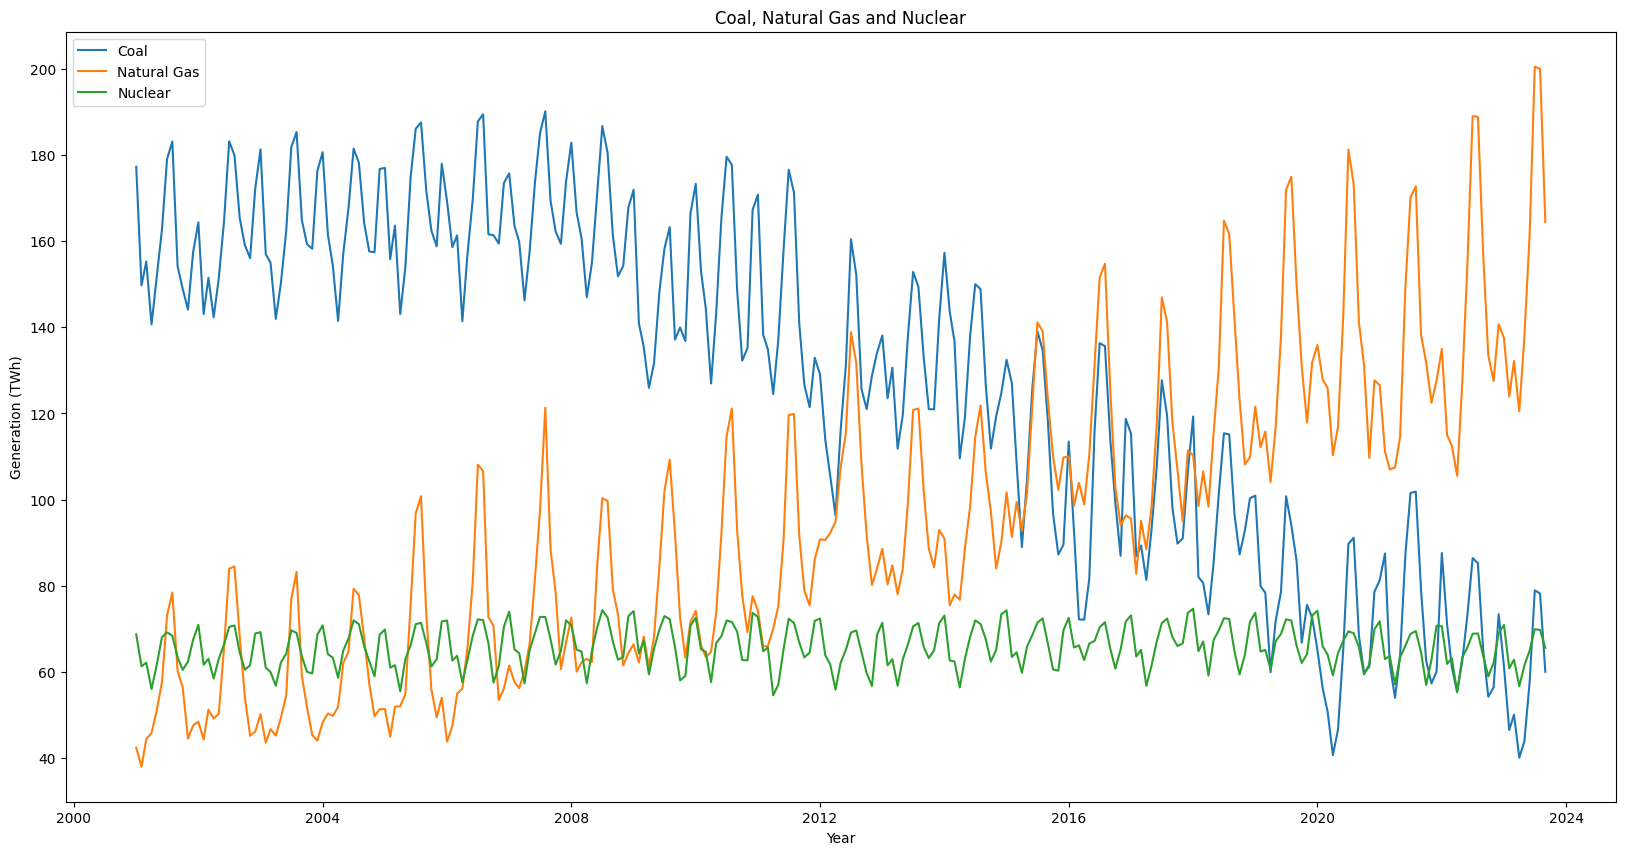

In [ ]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['DATE'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best')

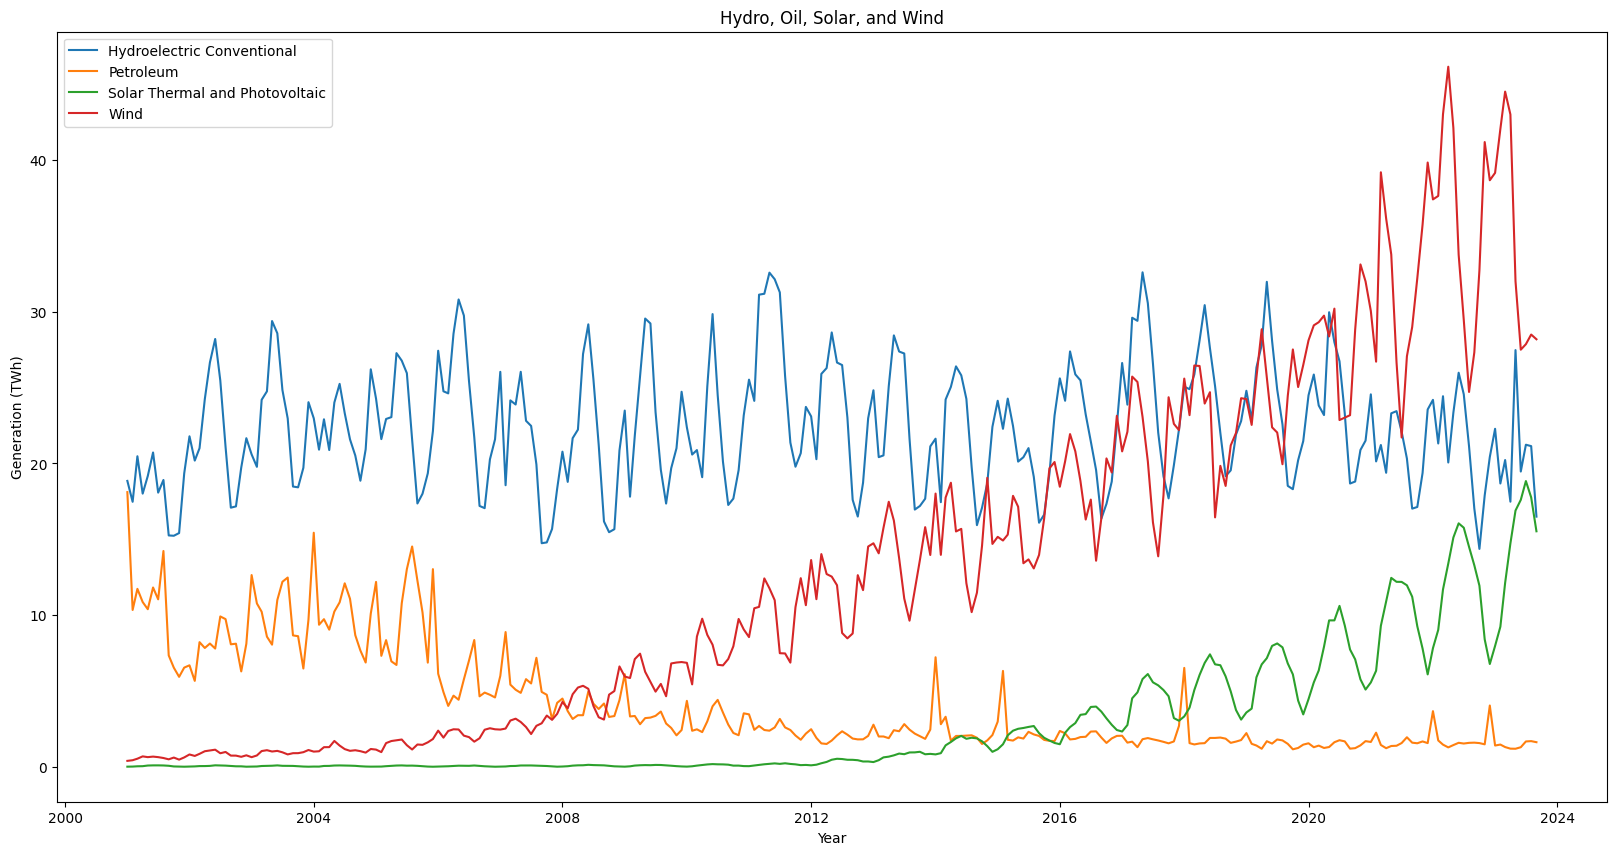

In [ ]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['DATE'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Hydro, Oil, Solar, and Wind")
plt.xlabel("Year")
plt.legend(loc='best')

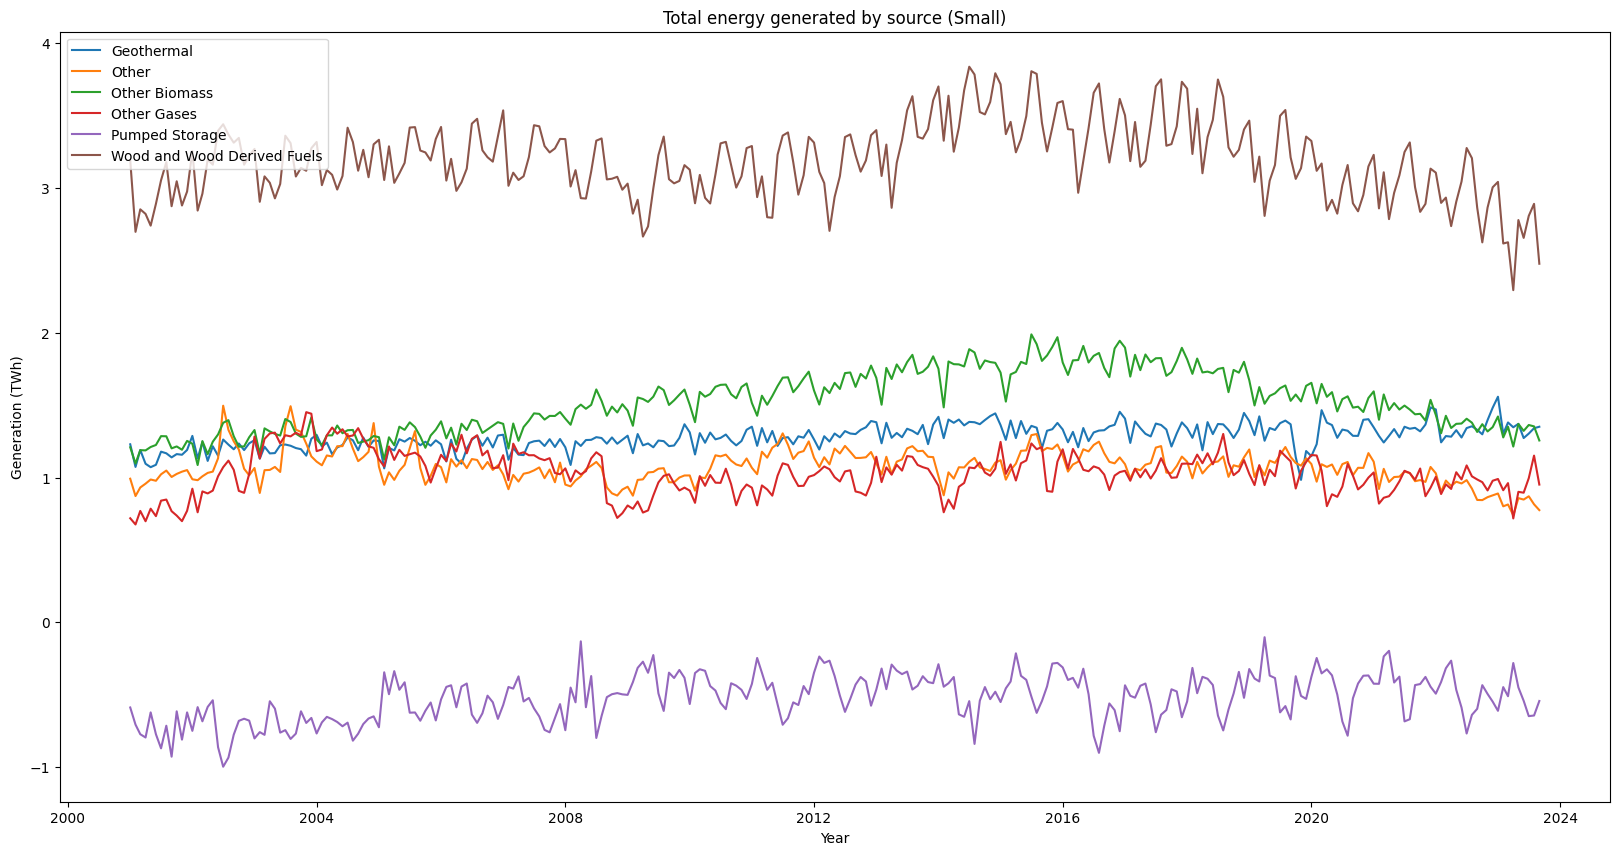

In [ ]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

plt.figure(figsize=(20,10))
sns.color_palette("deep")
sns.lineplot(data=US_bot, x=US_bot['DATE'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source (Small)")
plt.xlabel("Year")
plt.legend(loc='upper left')

We can also look at look at the three that look to be growing the most, Natrual gas, wind, and solar.

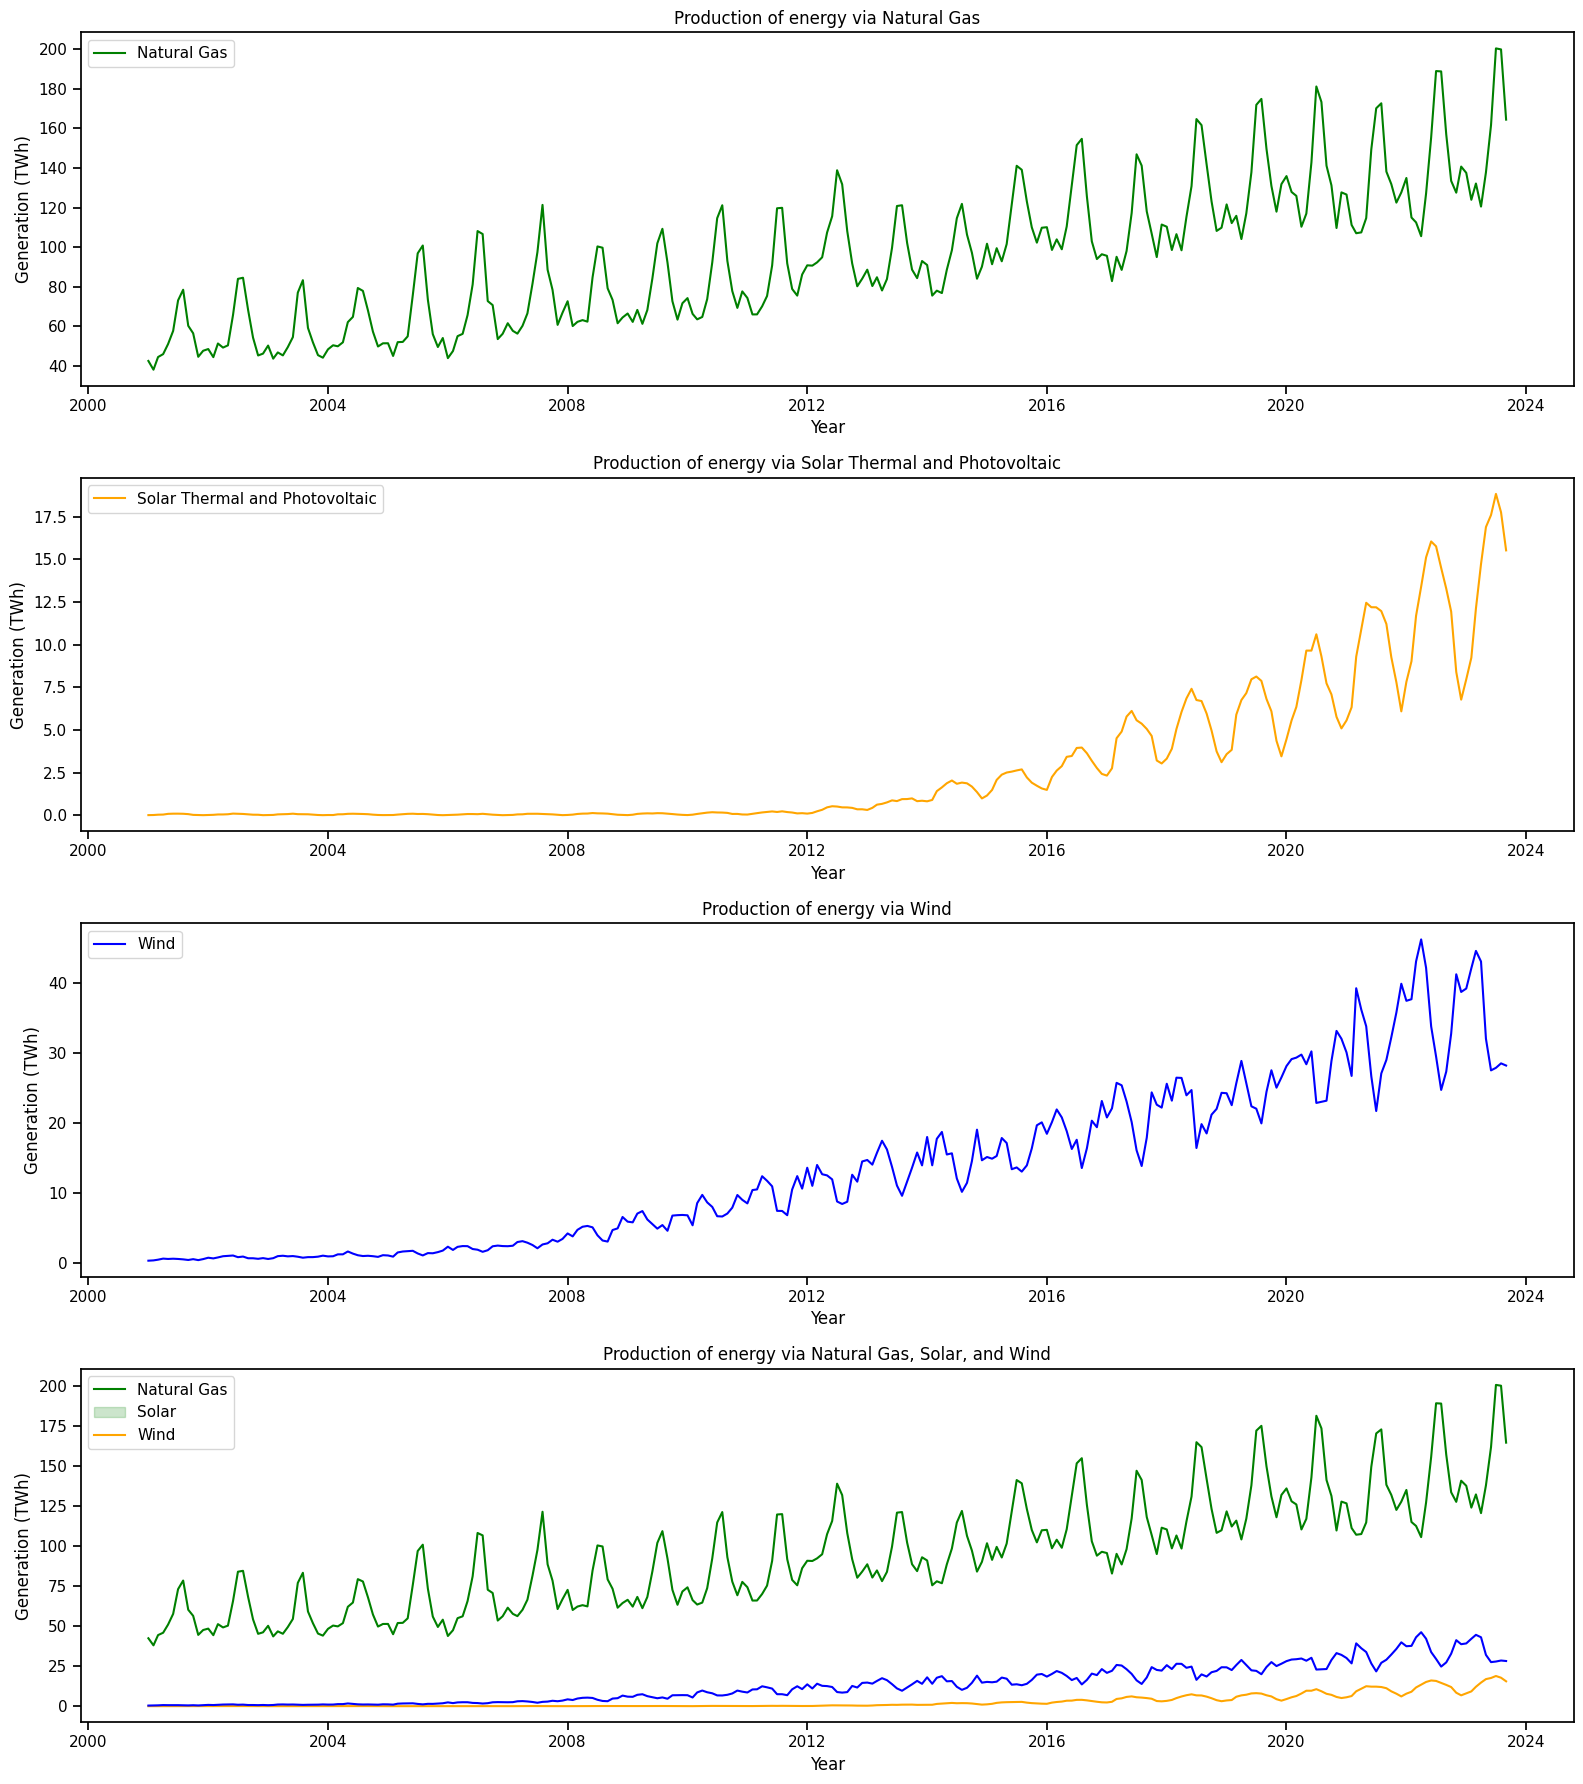

In [ ]:
sns.set_context("notebook")
fig, axs = plt.subplots(4, 1, figsize=(16, 18))

def plot_energy_source(ax, df, energy_source, color):
    source_data = df.loc[df['ENERGY SOURCE'] == energy_source]
    sns.lineplot(x=source_data.index, y=source_data['Generation (TWh)'], color=color, ax=ax)
    ax.set_title(f'Production of energy via {energy_source}')
    ax.set_xlabel("Year")
    ax.set_ylabel("Generation (TWh)")
    ax.legend([energy_source]) 

plot_energy_source(axs[0], US_total, 'Natural Gas', 'green')
plot_energy_source(axs[1], US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(axs[2], US_total, 'Wind', 'blue')
ax_combined = axs[3]

plot_energy_source(ax_combined, US_total, 'Natural Gas', 'green')
plot_energy_source(ax_combined, US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(ax_combined, US_total, 'Wind', 'blue')

ax_combined.set_title('Production of energy via Natural Gas, Solar, and Wind')
ax_combined.set_xlabel("Year")

ax_combined.legend(['Natural Gas', 'Solar', 'Wind'])

plt.tight_layout()
plt.show()

Plotted by themselves they look to grow very fast but when ploted together solar and windthe make up of net generation 

Who creates the most power? By state? By type of producer?

## Renewable Energy Growth by State:

In [ ]:
# Sean add solor data here

## 